# Unsupervised Anomaly Detection using SageMaker Random Cut Forest

*** This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 kernel***

---
Use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. The use the model to predict anomalous events by emitting an "anomaly score" for each data point. 

In [ ]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"

In [2]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 86.4 ms, sys: 11.5 ms, total: 98 ms
Wall time: 250 ms


In [3]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


<AxesSubplot:>

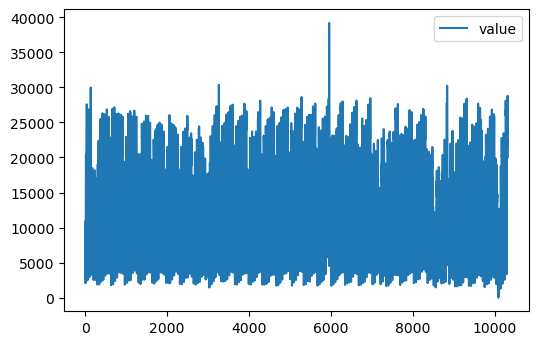

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

taxi_data.plot()

<AxesSubplot:>

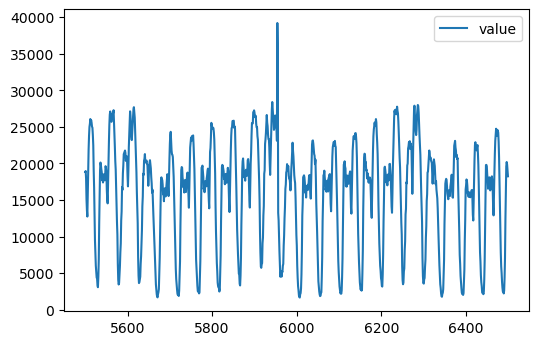

In [5]:
taxi_data[5500:6500].plot()

In [6]:
taxi_data[5952:6000]

,timestamp,value
5952,2014-11-02 00:00:00,25110
5953,2014-11-02 00:30:00,23109
5954,2014-11-02 01:00:00,39197
5955,2014-11-02 01:30:00,35212
5956,2014-11-02 02:00:00,13259
5957,2014-11-02 02:30:00,12250
5958,2014-11-02 03:00:00,10013
5959,2014-11-02 03:30:00,7898
5960,2014-11-02 04:00:00,6375
5961,2014-11-02 04:30:00,4532


## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [7]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-15 02:03:13 Starting - Starting the training job...ProfilerReport-1647309792: InProgress
...
2022-03-15 02:03:56 Starting - Preparing the instances for training.........
2022-03-15 02:05:37 Downloading - Downloading input data...
2022-03-15 02:05:57 Training - Downloading the training image......
2022-03-15 02:07:14 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[03/15/2022 02:07:06 INFO 140182803892032 integration.py:636] worker started
[03/15/2022 02:07:06 INFO 140182803892032] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_

# Inference

***

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [9]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!

In the AWS SageMaker console, select the endpoint matching the endpoint name, below: 

In [10]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2022-03-15-02-09-34-271


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [11]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [12]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


## Computing Anomaly Scores

In [13]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.963775
1,2014-07-01 00:30:00,8127,1.026238
2,2014-07-01 01:00:00,6210,0.981120
3,2014-07-01 01:30:00,4656,0.863219
4,2014-07-01 02:00:00,3820,0.899501


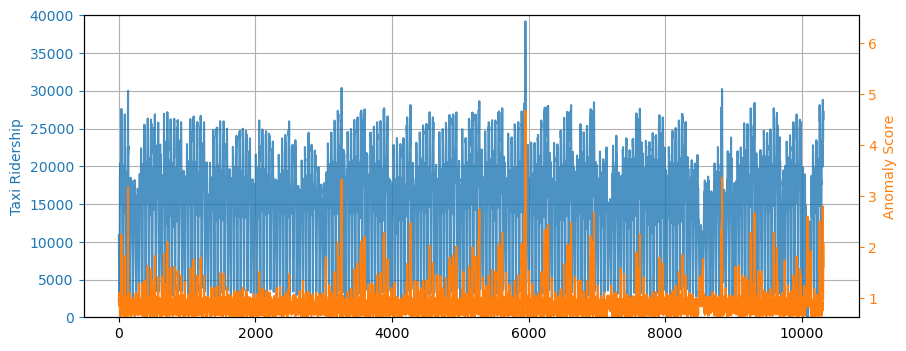

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
# start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

In [15]:
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.246658
38,2014-07-01 19:00:00,26827,1.811240
87,2014-07-02 19:30:00,26872,1.834946
134,2014-07-03 19:00:00,29985,3.177184
527,2014-07-11 23:30:00,26873,1.835433
...,...,...,...
10309,2015-01-31 18:30:00,27286,2.070776
10310,2015-01-31 19:00:00,28804,2.799579
10311,2015-01-31 19:30:00,27773,2.329284
10317,2015-01-31 22:30:00,27309,2.080245


The following is a list of known anomalous events which occurred in New York City within this timeframe:

* `2014-11-02` - NYC Marathon
* `2015-01-01` - New Year's Eve
* `2015-01-27` - Snowstorm

Note that our algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot.

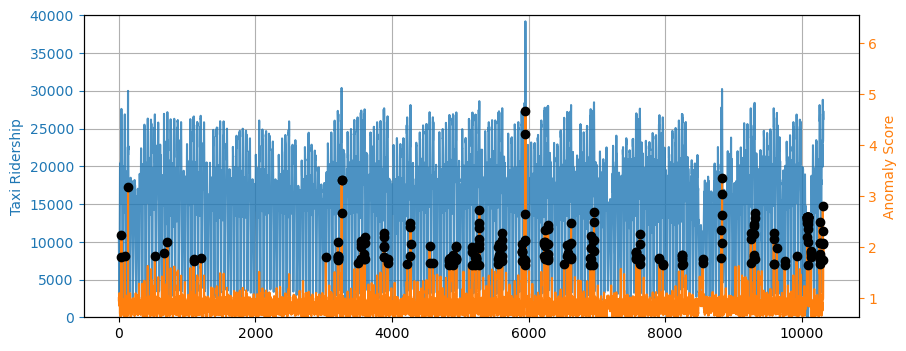

In [16]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Delete the Endpoint


In [17]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = "sagemaker/randomcutforest_shingled"
taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [19]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-15 02:14:38 Starting - Starting the training job...
2022-03-15 02:14:41 Starting - Launching requested ML instancesProfilerReport-1647310478: InProgress
.........
2022-03-15 02:16:31 Starting - Preparing the instances for training.........
2022-03-15 02:17:53 Downloading - Downloading input data...
2022-03-15 02:18:33 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/15/2022 02:18:38 INFO 140106765363008] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[03/15/2022 02:18:38 INFO 1401067653

In [20]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------!

In [21]:
print(rcf_inference.content_type, rcf_inference.accept)

text/csv ('application/json',)


Compute the anomaly scores associated with the shingled data.

In [22]:
# Score the shingled datapoints
results = rcf_inference.predict(
    taxi_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.49660652 1.43573977 1.5119168  1.55235087 1.57802392 1.66690834
 1.60666461 1.58321998 1.58952992 1.57033128 1.49519117 1.50879183
 1.5231317  1.50443458 1.50676664 1.44542408 1.55173564 1.6356701
 1.59682895 1.54979984 1.58464778 1.51171818 1.53195742 1.62439385
 1.59747739 1.54991215 1.58785083 1.56117744 1.51248576 1.56495411
 1.61604095 1.52597493 1.57463417 1.59368422 1.6585808  1.71842327
 1.65294684 1.70396769 1.71856377 1.50839117 1.47153418 1.43824919
 1.54423666 1.48672363 1.5150616  1.52161912 1.53068678 1.49229133
 1.57624857 1.53724043 1.51295537 1.4749543  1.44828556 1.48585275
 1.44832917 1.43377333 1.5023094  1.44130253 1.47503488 1.46859752
 1.47384063 1.55687248 1.44387061 1.47022518 1.45971287 1.46261631
 1.46260662 1.47696547 1.45237428 1.48445133 1.46639241 1.48530028
 1.44871118 1.45517781 1.4777865  1.47338873 1.47330825 1.46828207
 1.44210077 1.45391342 1.49543729 1.47920523 1.45785161 1.47776756
 1.52211916 1.56697051 1.6119617  1.6124953  1.65129866 1.68732

Plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

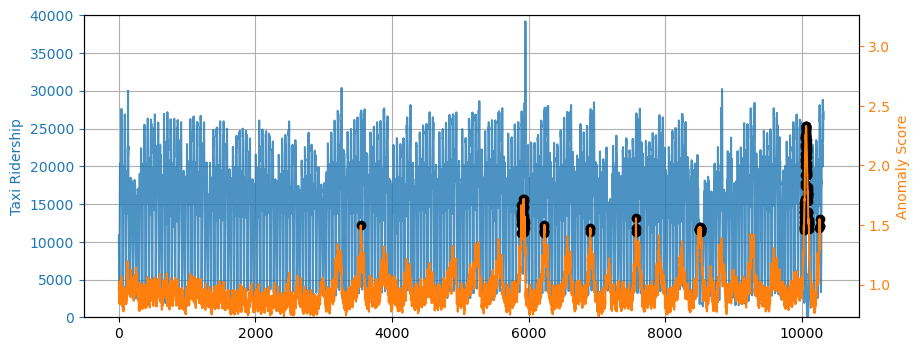

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data["value"], color="C0", alpha=0.8)
ax2.plot(scores, color="C1")
ax2.scatter(anomaly_indices, anomalies, color="k")

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000.

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)